In [22]:
import math
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords,RuleInductionType
from ema_workbench.analysis import clusterer, plotting, Density

#%matplotlib inline
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = os.path.dirname(os.getcwd()) + '\\1_Model'
sys.path.append(pydice_folder)

from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)

from PyRICE_V8 import PyRICE

from matplotlib import pyplot

In [23]:
results_total_short_term = pd.read_csv("experiments_short_term_uncertainty_total.csv")

results_total_short_term['Economic scenario'] = ""#df.loc[df['c1'] == 'Value', 'c2'] = 10
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 0,'Economic scenario'] = "Nordhaus scenario"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 1,'Economic scenario'] = "SSP1"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 2,'Economic scenario'] = "SSP2"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 3,'Economic scenario'] = "SSP3"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 4,'Economic scenario'] = "SSP4"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 5,'Economic scenario'] = "SSP5"

## Get right data format

In [24]:
list(results_total_short_term.columns)

experiments_columns = ['fdamage',
 'fosslim',
 'scenario_cback',
 'scenario_elasticity_of_damages',
 'scenario_limmiu',
 'scenario_pop_gdp',
 'scenario_sigma',
 't2xco2_dist',
 't2xco2_index',
 'scenario',
 'policy',
 'model',
 'sr',
 'irstp',
 'miu_period',
 'egalitarian_discounting',
 'principle',
 'sufficitarian growth factor',
 'sufficitarian_discounting',
 'treshold level',
 'growth_factor_prio',
 'prioritarian_discounting']

In [25]:
experiments = results_total_short_term[experiments_columns]

experiments = results_total_short_term[experiments_columns]
outcomes = results_total_short_term.iloc[:,18:142]

In [26]:
data_types = []

for column in list(outcomes.columns):
    data_type_found = outcomes[column].dtypes
    data_types.append(data_type_found)
    
x = np.array(data_types)


#### recode experiments

In [27]:
experiments['principle'].unique()

array(['Egalitarian', 'Sufficitarian', 'Prioritarian', 'Utilitarian',
       'Nordhaus policy'], dtype=object)

In [28]:
#combine growth factors
experiments['growth factor'] = np.where(experiments['growth_factor_prio'] > 0,experiments['growth_factor_prio'] ,"else")
experiments['growth factor'] = np.where(experiments['sufficitarian growth factor'] >0,experiments['sufficitarian growth factor'] ,"else")
#experiments['growth factor'] = np.where(experiments['growth factor'] =="else",0.0 ,experiments['growth factor'])

#combine discounting
experiments['discounting_method'] = ""
experiments['discounting_method'] = np.where(experiments['principle'] == "utilitarian" , experiments['irstp'], 0)
experiments['discounting_method'] = np.where(experiments['irstp'] > 0.005 , 0, 1)

experiments['discounting_method'] = np.where(experiments['prioritarian_discounting'] == 0, 2,experiments['discounting_method'])
experiments['discounting_method'] = np.where(experiments['prioritarian_discounting'] == 1, 3,experiments['discounting_method'])

experiments['discounting_method'] = np.where(experiments['sufficitarian_discounting'] == 0,4 ,experiments['discounting_method'])
experiments['discounting_method'] = np.where(experiments['sufficitarian_discounting'] == 1,5 ,experiments['discounting_method'])

experiments['discounting_method'] = np.where(experiments['egalitarian_discounting'] == 0, 6 ,experiments['discounting_method'])
experiments['discounting_method'] = np.where(experiments['egalitarian_discounting'] ==1, 7,experiments['discounting_method'])

#treshold level
experiments['treshold level'] = np.where(experiments['principle'] != "Sufficitarian"  , 0.7,experiments['treshold level'])

#principle
experiments['principle_recoded'] = 0
experiments['principle_recoded'] = np.where(experiments['principle'] == "Nordhaus policy" , int(4), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Utilitarian" , int(0), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Prioritarian" , int(1), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Sufficitarian" , int(2), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Egalitarian" , int(3), experiments['principle_recoded'])

<ipython-input-28-43dfb4ef5794>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiments['growth factor'] = np.where(experiments['growth_factor_prio'] > 0,experiments['growth_factor_prio'] ,"else")
<ipython-input-28-43dfb4ef5794>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiments['growth factor'] = np.where(experiments['sufficitarian growth factor'] >0,experiments['sufficitarian growth factor'] ,"else")
<ipython-input-28-43dfb4ef5794>:7: SettingWithCopyWarning: 
A value is trying to be set on 

In [29]:
data_types = []

for column in list(experiments.columns):
    data_type_found = experiments[column].dtypes
    data_types.append(data_type_found)
    
x = np.array(data_types)

In [30]:
#removed principle and growth factor because of strings result in pandas cells when recoding
experiments_input_total = experiments[['fdamage', 'fosslim', 'scenario_cback',
       'scenario_elasticity_of_damages', 'scenario_limmiu', 'scenario_pop_gdp',
       'scenario_sigma', 't2xco2_dist', 't2xco2_index','treshold level','principle_recoded',
       'sr', 'irstp', 'miu_period', 'discounting_method']]

In [31]:
#check for strings that ruin  the regresson
data_types = []

for column in list(experiments_input_total.columns):
    data_type_found = experiments_input_total[column].dtypes
    data_types.append(data_type_found)
    
x = np.array(data_types) 
x

array([dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('int64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('int32')], dtype=object)

## Feature scoring short term with random forest

In [32]:
year = [2045,2075,2105]

In [33]:
timepoints_to_save = np.arange(2045,2105+10,30)
objectives_list_name = ['Intertemporal utility GINI','Intertemporal impact GINI','Total Aggregated Utility']

objectives_list_timeseries_name = ['Damages ','Utility ',
            'Lowest income per capita ','Highest climate impact per capita ',
            'Distance to treshold ','Population under treshold ',
            'Intratemporal utility GINI ','Intratemporal impact GINI ',
            'Atmospheric Temperature ', 'Industrial Emission ', 'Total Output ']

supplementary_list_timeseries_name = ['CPC ','Population ']
supplementary_list_quintile_name = ['CPC pre damage ','CPC post damage ']

outcomes_names_time_series = []
for name in objectives_list_timeseries_name:
    for year in timepoints_to_save:
        name_year = name + str(year)
        outcomes_names_time_series.append(name_year)

outcomes_name_single = []
outcomes_name_multiple= []
for name in objectives_list_name:
    outcomes_name_single.append(name)

In [34]:
outcomes_names_main = outcomes_names_time_series+outcomes_name_single

In [35]:
outcomes_feature_score = outcomes[outcomes_names_main]
experiments_input_total[["fdamage", "scenario_cback","scenario_elasticity_of_damages",
                   "scenario_limmiu","scenario_pop_gdp","scenario_sigma","t2xco2_dist",'miu_period',
                   "t2xco2_index","principle_recoded","discounting_method"]] = experiments_input_total[["fdamage", "scenario_cback","scenario_elasticity_of_damages",
                   "scenario_limmiu","scenario_pop_gdp","scenario_sigma","t2xco2_dist",'miu_period',
                   "t2xco2_index","principle_recoded","discounting_method"]].astype(int)


C:\Users\ivart\anaconda3\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [36]:
from ema_workbench.analysis import feature_scoring

In [37]:
#experiments_input = pd.read_csv('experimentsinput.csv')
#outcomes_feature_score = pd.read_csv('outcomes_feature_score.csv')

In [38]:
#test with small data set
#experiments_input = experiments_input_total[0:1000]
#outcomes_feature_score = outcomes_feature_score[0:1000]

#experiments_input.to_csv('experimentsinput.csv')
#outcomes_feature_score.to_csv('outcomes_feature_score.csv')

#drop non categorical columns --> should be recoded later
#experiments_input = experiments_input.drop(['t2xco2_index','sr','irstp','treshold level','fosslim','miu_period'],axis=1)

In [39]:
experiments_input_total

,fdamage,fosslim,scenario_cback,scenario_elasticity_of_damages,scenario_limmiu,scenario_pop_gdp,scenario_sigma,t2xco2_dist,t2xco2_index,treshold level,principle_recoded,sr,irstp,miu_period,discounting_method
0,2,7099.419397,0,0,0,3,0,2,682,0.7,3,0.474765,0.006911,28,6
1,0,13291.503245,1,2,1,2,0,1,884,0.7,3,0.474765,0.006911,28,6
2,0,5911.972098,1,2,1,3,1,2,709,0.7,3,0.474765,0.006911,28,6
3,2,6148.027602,1,2,1,1,2,1,395,0.7,3,0.474765,0.006911,28,6
4,2,7229.580767,1,2,0,1,1,0,31,0.7,3,0.474765,0.006911,28,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049995,2,5667.799981,1,2,1,1,1,0,779,0.7,4,0.248000,0.015000,13,0
1049996,2,6660.323400,1,0,1,2,0,0,169,0.7,4,0.248000,0.015000,13,0
1049997,0,8769.036526,1,2,0,1,0,1,252,0.7,4,0.248000,0.015000,13,0
1049998,1,8134.068795,1,2,0,2,0,2,166,0.7,4,0.248000,0.015000,13,0


In [40]:
outcomes_feature_score

,Damages 2045,Damages 2075,Damages 2105,Utility 2045,Utility 2075,Utility 2105,Lowest income per capita 2045,Lowest income per capita 2075,Lowest income per capita 2105,Highest climate impact per capita 2045,...,Atmospheric Temperature 2105,Industrial Emission 2045,Industrial Emission 2075,Industrial Emission 2105,Total Output 2045,Total Output 2075,Total Output 2105,Intertemporal utility GINI,Intertemporal impact GINI,Total Aggregated Utility
0,0.031112,0.328447,1.068856,3473.514687,3722.426030,3721.552910,0.740175,0.827525,0.862962,0.000528,...,2.674781,11.743266,8.487393,6.277621,168.759388,215.481953,254.819465,0.689137,0.877195,3693.990723
1,2.501581,7.812991,15.549950,4933.170802,7409.516255,8725.699895,0.992562,1.411637,1.271357,0.170799,...,4.024118,13.402452,10.859952,8.020309,204.961764,304.356284,377.345558,0.707413,0.828309,5087.475335
2,0.388916,1.209310,0.807160,3460.323087,3663.369226,3721.063165,0.727864,0.763367,0.829634,0.063678,...,0.000000,14.735281,12.437910,10.141211,168.256861,214.193496,254.267620,0.689061,0.781916,3684.179079
3,0.187219,4.526043,21.891184,5560.373974,7463.451328,7418.777375,1.573832,2.668239,0.689727,0.013997,...,3.941174,11.090208,7.420825,4.483401,221.234167,327.450499,372.119961,0.716210,0.896096,5088.188724
4,0.040908,0.962932,4.893565,5562.795071,7510.045095,7586.741949,1.589935,3.209291,3.965026,0.003061,...,3.137912,18.837363,19.001491,15.949221,221.320063,330.756361,388.556411,0.718278,0.897431,5104.519137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049995,0.044206,0.701238,2.102540,3280.260508,2861.628351,1878.306034,1.773708,3.959747,6.068778,0.002965,...,2.765923,15.206940,10.544129,3.545464,220.624110,327.850340,384.150146,0.733883,0.878312,1222.930416
1049996,0.091340,1.523923,5.321011,3017.360770,2962.907388,2276.677113,1.321742,2.626080,4.101601,0.001132,...,3.174208,11.155709,6.487749,2.062105,206.917883,308.872783,383.798675,0.724897,0.883872,1219.159165
1049997,1.697423,4.056454,5.928984,3265.794267,2855.723911,1879.584447,1.617662,3.484943,5.320774,0.100599,...,2.066675,12.682378,8.459209,4.120251,219.397506,326.715455,385.728392,0.734371,0.799734,1218.541783
1049998,2.350961,8.588262,16.041575,2981.441995,2917.750195,2245.913114,1.108675,1.728971,2.167149,0.169099,...,3.024115,11.958644,8.042894,4.175579,204.857305,302.626532,374.861064,0.723840,0.832298,1205.609514


In [41]:
import time
feature_score_df = pd.DataFrame()
count = 0

for outcome in outcomes_names_main:
    
    #get outcome output array of 1.05 million outcomes
    outcome_array = outcomes_feature_score[outcome].to_numpy(dtype=float)
    
    start = time.time()
    print("extra trees started for: " + outcome)
    
    #calculate feature score of outcome based on random forest regression
    k = feature_scoring.get_ex_feature_scores(experiments_input_total,outcome_array,mode = RuleInductionType.REGRESSION)  
    
    feature_score_df[outcome] = k[0].iloc[:,0]
    end = time.time()
    
    del k
    
    print('Regression time is ' + str(round((end - start))) + ' secondes')
    print("")

    count = count + 1
    
    print("determined feature score of: " + str(count) + "/" + str(len(outcomes_names_main[9:])))   
    

extra trees started for: Damages 2045
Regression time is 94 secondes

determined feature score of: 1/27
extra trees started for: Damages 2075
Regression time is 84 secondes

determined feature score of: 2/27
extra trees started for: Damages 2105
Regression time is 82 secondes

determined feature score of: 3/27
extra trees started for: Utility 2045
Regression time is 73 secondes

determined feature score of: 4/27
extra trees started for: Utility 2075
Regression time is 72 secondes

determined feature score of: 5/27
extra trees started for: Utility 2105
Regression time is 73 secondes

determined feature score of: 6/27
extra trees started for: Lowest income per capita 2045
Regression time is 87 secondes

determined feature score of: 7/27
extra trees started for: Lowest income per capita 2075
Regression time is 87 secondes

determined feature score of: 8/27
extra trees started for: Lowest income per capita 2105
Regression time is 85 secondes

determined feature score of: 9/27
extra trees s

In [42]:
#feature_1 = pd.read_csv("featurescore_utility3_lowest_income_per_capita.csv" )
#feature_1 = feature_1.set_index(feature_1.columns[0])
#feature_1.index.name = 'uncertainty'
#feature_2 = pd.read_csv("featurescore_utility2-3.csv")
#feature_2 = feature_2.set_index(feature_2.columns[0])
#feature_2.index.name = 'uncertainty'
#feature_3 = pd.read_csv("featurescore_damages.csv")
#feature_3= feature_3.set_index(feature_3.columns[0])
#feature_3.index.name = 'uncertainty'#

#total_feature_scores = pd.concat([feature_1,feature_2,feature_3,feature_score_df],axis = 1)
#total_feature_scores.sort_index(inplace=True, axis=1)

feature_score_df.to_csv("total_feature_scores_short_term_uncertainty_analysis.csv",float_format='%.3f')

In [43]:
total_feature_scores = pd.read_csv("total_feature_scores_short_term_uncertainty_analysis.csv")
total_feature_scores= total_feature_scores.set_index(total_feature_scores.columns[0])

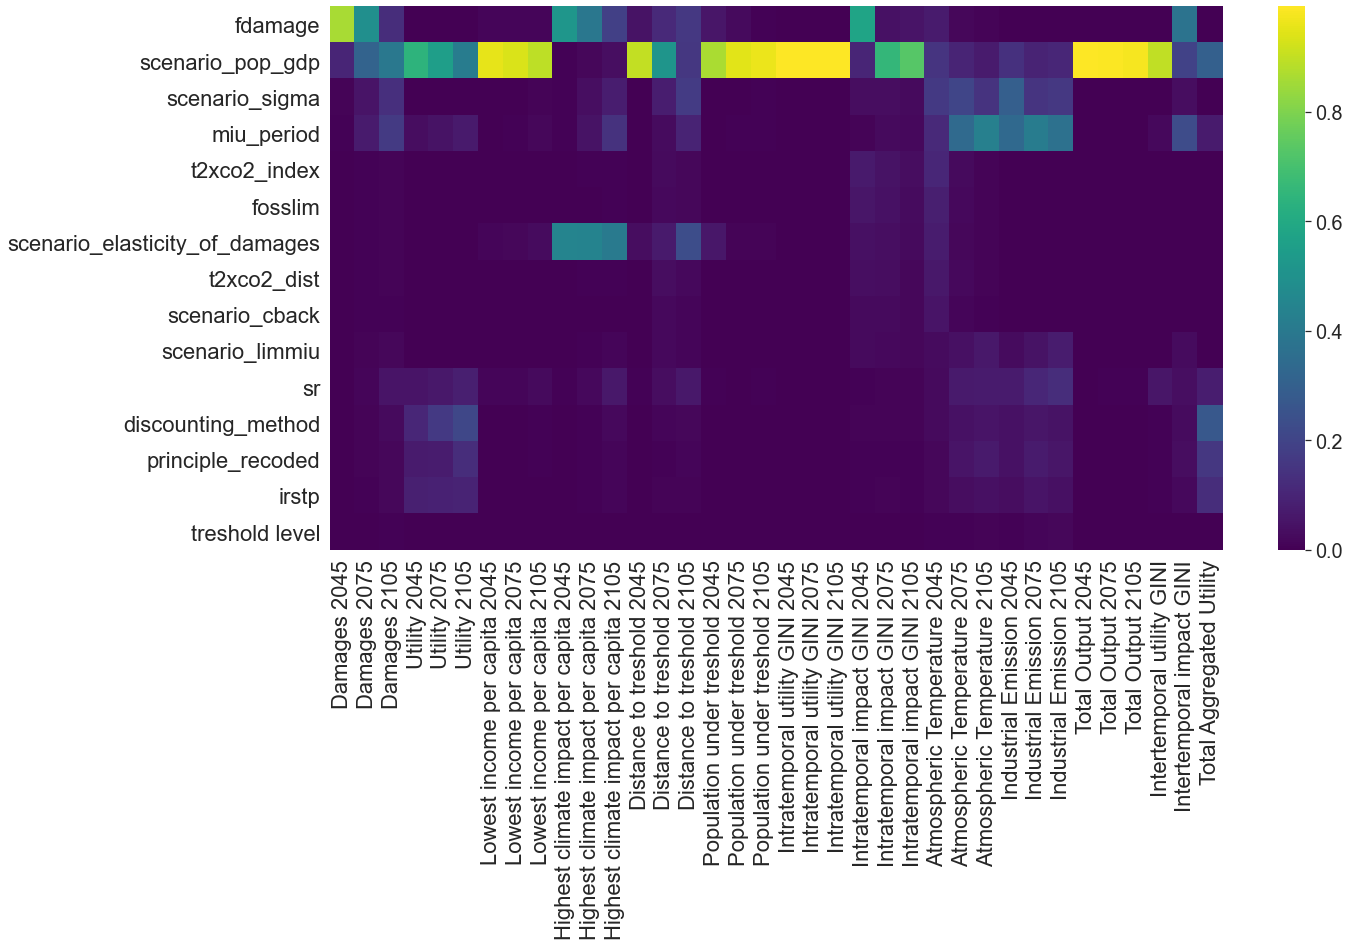

In [44]:
sns.set(font_scale=1.8)

fig, ax = plt.subplots(figsize=(20,10))         

sns.heatmap(total_feature_scores, cmap='viridis', annot=False,ax=ax)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 22)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 22)
ax.set_xticklabels(ax.get_xmajorticklabels(),rotation=90) 
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()

fig.savefig('feature_scoring_heatmap_short_term.png', dpi=200,bbox_inches='tight')